# BENG 203
# Course project

## Dependencies\

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import pickle
import os
# Silence warnings to avoid multiple messages from a foreseen error.
import warnings
warnings.filterwarnings('ignore')
plt.rcParams['figure.dpi'] = 300

## General arguments\

In [2]:
# ---> Paths.
course_path = '/Users/vfajardo/iCloud_Drive/UCSD_classes/year-1_spring-quarter/BENG_203'
prj_path = course_path + '/project'
data_path = prj_path + '/data'
results_path = prj_path + '/results'
feats_path = results_path + '/feature_engineering'
# ---> File definitions.
# @ Expression data.
cancer_train_tpm_file = data_path + '/MergedTPMData.csv'
cancer_test_tpm_file = data_path + '/validation_exon_tpm.tsv'
# @ Metadata.
cancer_train_meta_file = data_path + '/MergedMetadata.csv'
cancer_test_meta_file = data_path + '/ValidationSamplesMetadata.csv'
gene_types_file = data_path + '/EnsemblGeneBiotypes_GRCh38.csv'
# @ Feature-related data.
# Cancer-related features.
cancer_feats_file = feats_path + '/DEA-Cancer_C-vs-N.csv'
# Recurrence-related features.
rec_feats_file = feats_path + '/DEA-Recurrence_R-vs-N.csv'

## General functions\

#### A function to save objects\

In [3]:
def SaveObj(this_object, file_pfx):
    # Save assessment dictionary
    tmp_file_name = file_pfx + '.pickle'
    tmp_file_name = os.path.join(results_path, tmp_file_name)
    file_to_store = open(tmp_file_name, "wb")
    pickle.dump(this_object, file_to_store)
    file_to_store.close()

## Load data\

In [13]:
# ---> Expression data.
# cancer_train_tpm = pd.read_csv(cancer_train_tpm_file, header=None, index_col=0, sep='\t')
cancer_train_tpm = pd.read_csv(cancer_train_tpm_file, index_col='geneid')
cancer_test_tpm = pd.read_csv(cancer_test_tpm_file, sep='\t')
# ---> Meta data
# cancer_train_meta = pd.read_csv(cancer_train_meta_file, index_col='sample_id')
cancer_train_meta = pd.read_csv(cancer_train_meta_file, index_col='sample.id')
cancer_test_meta = pd.read_csv(cancer_test_meta_file, index_col='sample_id')
gene_types = pd.read_csv(gene_types_file)
# ---> Condition-related features.
cancer_feats = pd.read_csv(cancer_feats_file, index_col='gene.id')
rec_feats = pd.read_csv(rec_feats_file, index_col='gene.id')

## Preprocess data\

In [14]:
# ---> Expression data.
# Set unique sample IDs.
cancer_train_tpm.columns = cancer_train_meta.index
# Uniquely valid features will be those present in both training and test datasets.
train_genes, test_genes = set(cancer_train_tpm.index.values), set(cancer_test_tpm.index.values)
print(len(train_genes) == len(train_genes.intersection(test_genes)))
# Set predictor variables.
X_train = cancer_train_tpm.T
X_test = cancer_test_tpm.T.loc[:, X_train.columns]
# X_test = cancer_test_tpm.T.loc[:, X_train.columns].values
# X_train = X_train.values
# Lucky us, both have been mapped to the exact same reference.
# ---> Metadata (target variable to be taken for either dataset)
# Of interest is the breast cancer status of each sample.
if all(cancer_train_meta.isin(cancer_train_tpm.columns)):
    cancer_train_tpm = cancer_train_tpm.loc[:, cancer_train_meta.index.values]
    y_train = cancer_train_meta.loc[:, ['disease.status']]
    y_train = cancer_train_meta.loc[:, ['disease.status']].values
    y_train = (y_train=='cancer')*1
else:
    raise ValueError('Training data misaligned.\n')
if all(cancer_test_meta.isin(cancer_test_tpm.columns)):
    cancer_test_tpm = cancer_test_tpm.loc[:, cancer_test_meta.index.values]
    y_test = cancer_test_meta.loc[:, ['cancer_status']].values
    y_test = (y_test=='cancer')*1
else:
    raise ValueError('Test data misaligned.\n')
# Gene biotypes.
gene_types.columns = ['gene_id', 'biotype']

# ---> Condition-related features
# Subset info to keep info relevant to rank the features.
cancer_feats['abs_lfc'] = np.abs(cancer_feats['lfc..minimum'])
cancer_feats['adj_p'] = cancer_feats['p.adj..maximum']
cancer_rank = cancer_feats.loc[:, ['abs_lfc', 'adj_p']]
# Include non-assessed features.
eng_feats = set(cancer_rank.index.values)
all_feats = set(cancer_train_tpm.index.values)
left_feats = all_feats.difference(eng_feats)
left_feats = {'gene.id':list(left_feats), 'abs_lfc':np.repeat(None, len(left_feats)), 'adj_p':np.repeat(None, len(left_feats))}
left_feats = pd.DataFrame.from_dict(left_feats)
left_feats = left_feats.set_index('gene.id')
cancer_rank = pd.concat([cancer_rank, left_feats])
# Rank features and set cummulative percentage.
cancer_rank = cancer_rank.sort_values(by=['abs_lfc', 'adj_p'], ascending=[True, False])
cancer_rank['rank'] = np.arange(1, cancer_rank.shape[0]+1)
cancer_rank['cumm_percent'] = (cancer_rank['rank']*100)/cancer_rank.shape[0]

True


## Further data exploration\

#### snoRNAs that are differentially expressed between cancer and non-cancer samples\

In [21]:
feat_subset = gene_types.loc[gene_types['biotype']=='snoRNA', 'gene_id']
feat_subset = feat_subset[feat_subset.isin(X_test.columns.values)].values
len(feat_subset)

939

In [20]:
feat_subset = gene_types.loc[gene_types['biotype']=='snoRNA', 'gene_id']
feat_subset = feat_subset[feat_subset.isin(X_train.columns.values)].values
len(feat_subset)

939

In [25]:
tmp_data = cancer_feats.merge(gene_types, left_index=True, right_on='gene_id')
tmp_data

,lfc..minimum,lfc.control,lfc.se.control,p.adj..maximum,p.adj.control,p.val.control,test.stat.control,mean.tpm.control,mean.tpm.cancer,abs_lfc,adj_p,gene_id,biotype
20783,0.259479,0.259479,0.217941,0.530332,0.530332,0.234336,1.189263,14.164084,21.437919,0.259479,0.530332,ENSG00000000003,protein_coding
20779,0.285348,0.285348,0.298568,0.635478,0.635478,0.340227,0.953718,16.256396,25.824944,0.285348,0.635478,ENSG00000000005,protein_coding
20915,0.306443,0.306443,0.301675,0.612728,0.612728,0.313699,1.007492,14.221749,23.245797,0.306443,0.612728,ENSG00000000419,protein_coding
46710,-0.172090,-0.172090,0.219941,0.707074,0.707074,0.433194,-0.783737,12.161375,13.742320,0.172090,0.707074,ENSG00000000457,protein_coding
45006,-0.213192,-0.213192,0.193605,0.570593,0.570593,0.270999,-1.100765,16.063505,16.954631,0.213192,0.570593,ENSG00000000460,protein_coding
...,...,...,...,...,...,...,...,...,...,...,...,...,...
61374,0.543567,0.543567,0.344133,0.370763,0.370763,0.114403,1.578706,8.978616,20.446707,0.543567,0.370763,ENSG00000283108,lncRNA
20999,-0.093806,-0.093806,0.296680,0.898512,0.898512,0.751564,-0.316578,8.046123,9.703975,0.093806,0.898512,ENSG00000283117,lncRNA
51979,0.235160,0.235160,0.355525,0.766215,0.766215,0.513355,0.653622,12.401986,20.658275,0.235160,0.766215,ENSG00000283118,lncRNA
22532,-0.169926,-0.169926,0.260306,0.766763,0.766763,0.513920,-0.652746,10.841728,11.762477,0.169926,0.766763,ENSG00000283122,lncRNA


In [37]:
tmp_data.loc[(tmp_data['adj_p']<0.05) & (tmp_data['biotype']=='snoRNA'), :]

,lfc..minimum,lfc.control,lfc.se.control,p.adj..maximum,p.adj.control,p.val.control,test.stat.control,mean.tpm.control,mean.tpm.cancer,abs_lfc,adj_p,gene_id,biotype
34891,-2.272754,-2.272754,0.213187,3.323485e-23,3.323485e-23,1.808311e-26,-10.64661,537.88419,130.107368,2.272754,3.323485e-23,ENSG00000222604,snoRNA


#### Number of genes per biotype

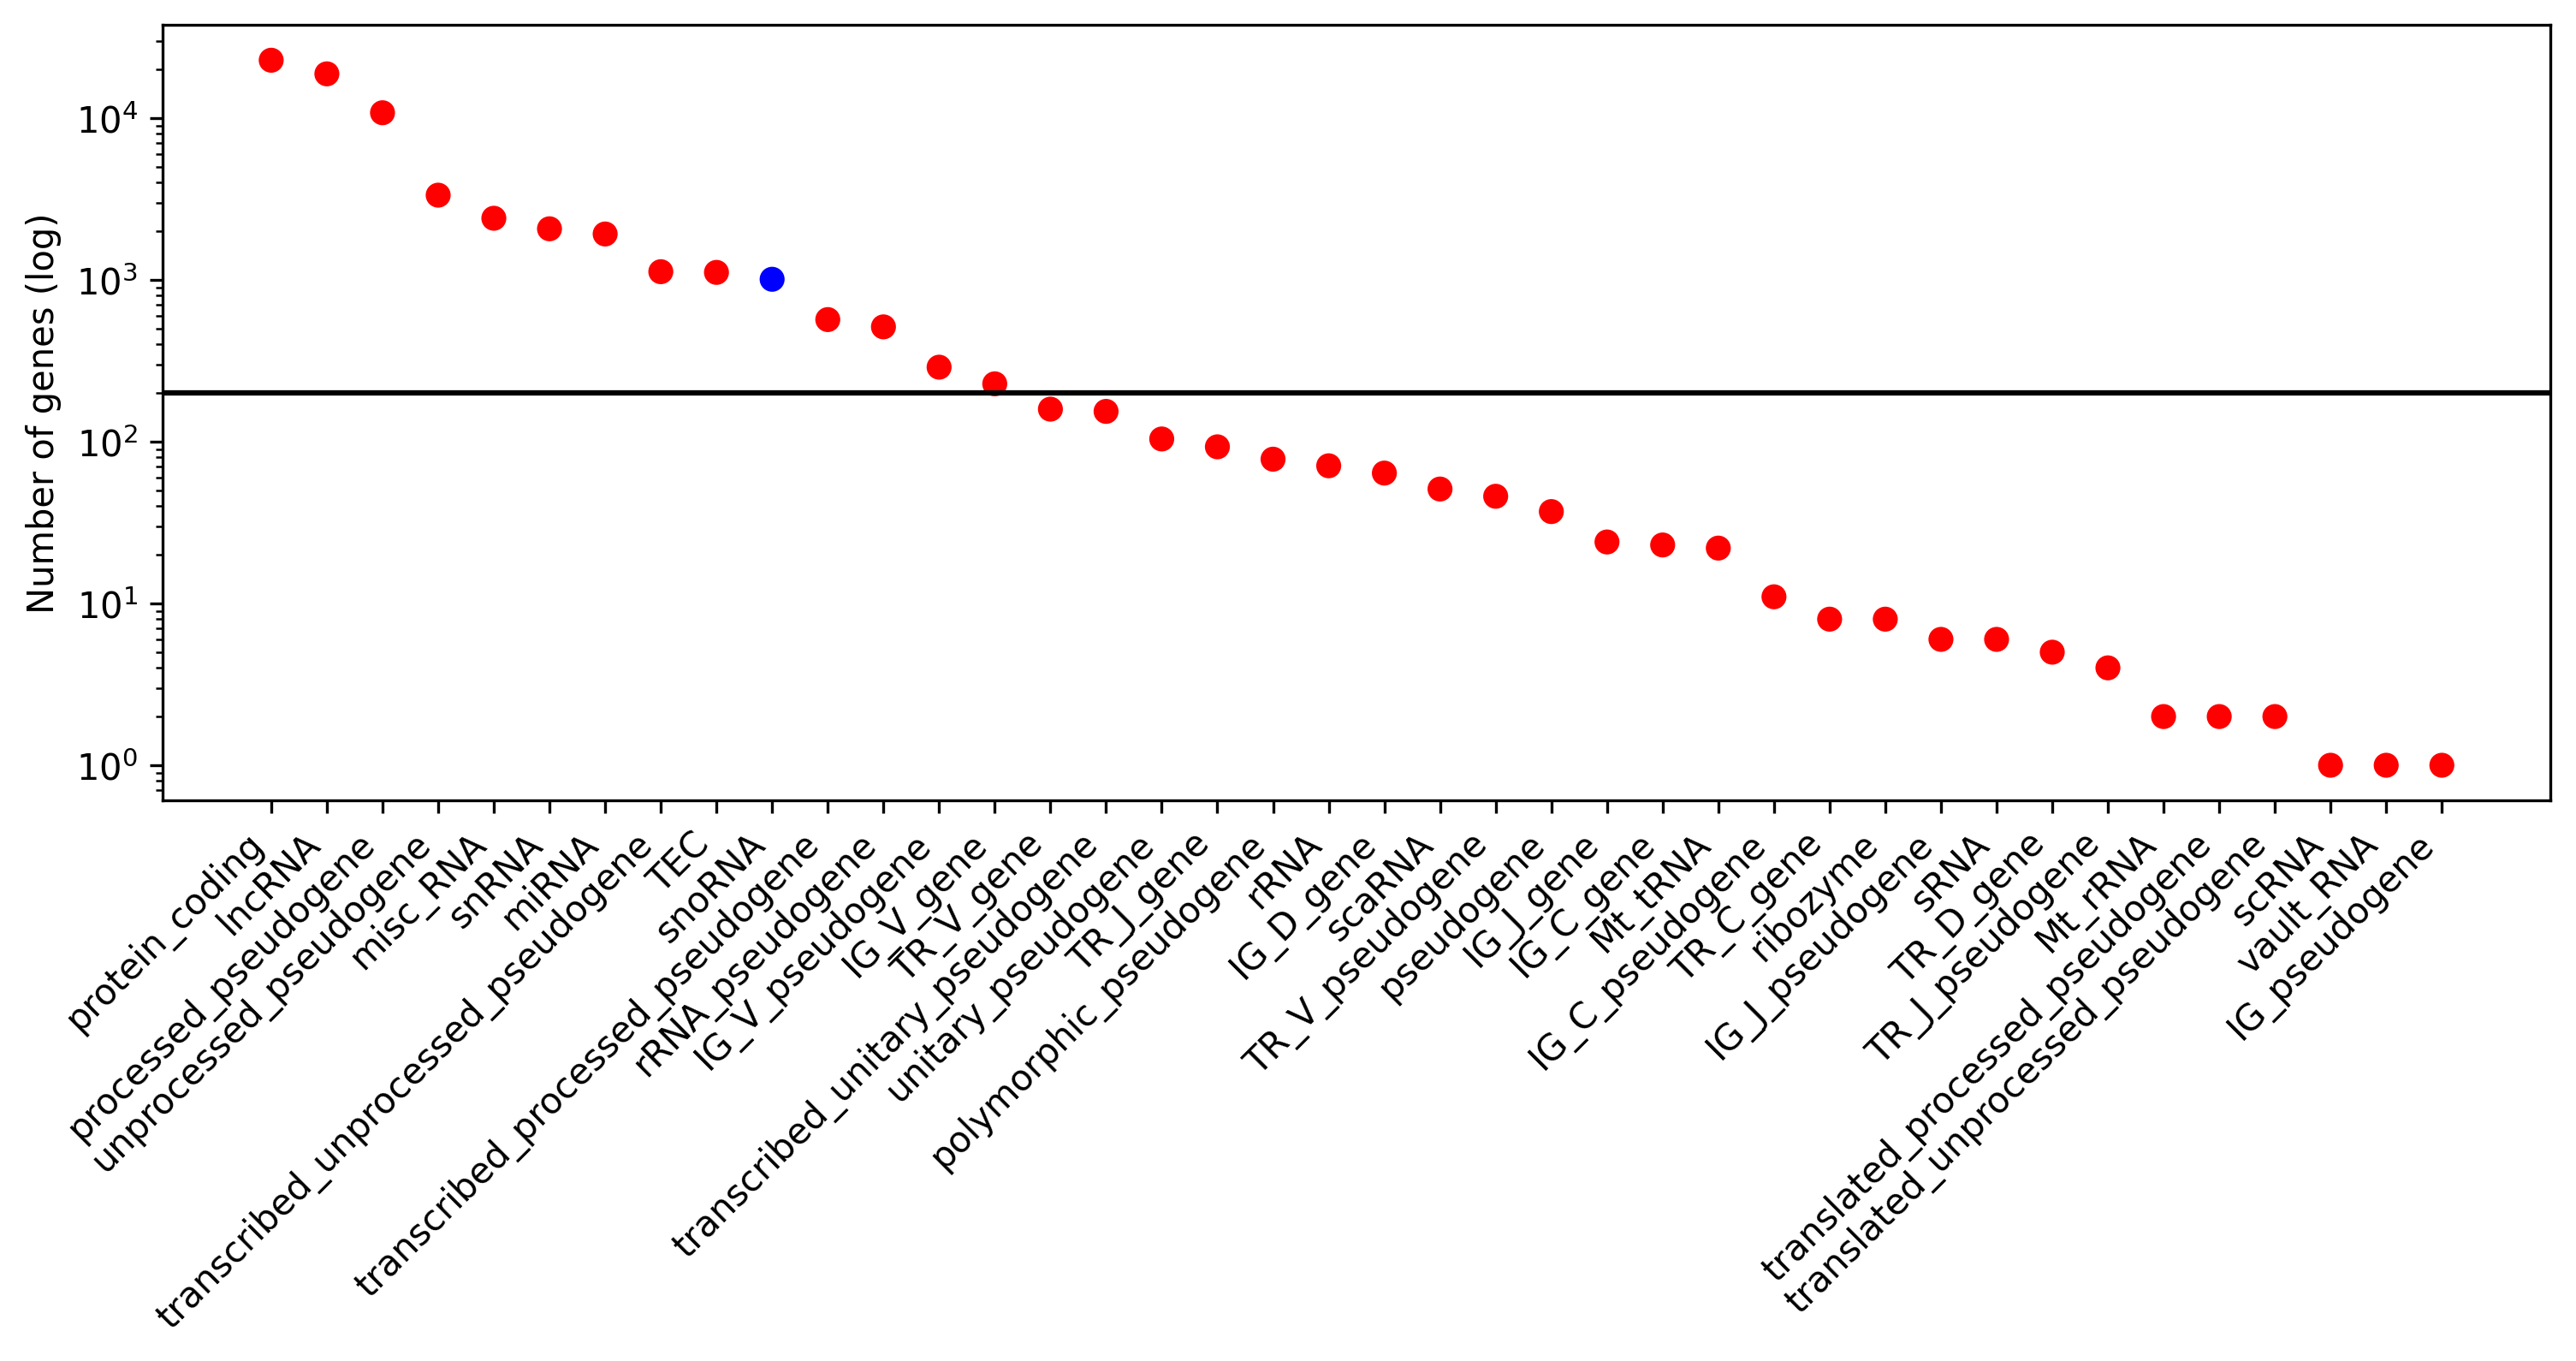

In [84]:
# Get data
tmp_data = pd.DataFrame(gene_types['biotype'].value_counts())
tmp_data.columns = ['Count']
tmp_data.sort_values('Count', ascending=False)
# tmp_data.index.values == 'snoRNA'
# tmp_data['is_snorna'] = tmp_data.index.values == 'snoRNA'
to_check = tmp_data.index.values=='snoRNA'
tmp_cols = ['blue' if i==True else 'red' for i in to_check]
# Plot.
xlabels = list(tmp_data.index)
fig, ax = plt.subplots(figsize=(12, 4))
ax.scatter(tmp_data.index.values, tmp_data.Count, c=tmp_cols)
ax.set_yscale('log')
ax.set_ylabel('Number of genes (log)')
ax.set_xticklabels(xlabels, rotation = 45, ha='right')
plt.axhline(y = 200, color = 'black', label = 'axvline - full height')
plt.show()

# Cancer prediction\

### Load needed sklearn models and tools\

In [7]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_curve

# Cancer prediction according to ranked features (based on LFC)

### Define general pipeline to train models according to ranked gene subset\

In [67]:
def GeneralClassifierPipeline(clas_model, model_lab, param_grid, defined_range=None, search_scoring='accuracy', cv_no=5):
    # ---> Define objects to save the models and the reports on testing data.
    model_list = list()
    eval_list = list()
    scores_list = list()
    # ---> Apply pipeline to each subset.
    print('Instancing models.')
    if defined_range is None:
        defined_range = np.arange(5, 105, 5)
    for i in defined_range:
#         print('Percent of data:' + str(i))
        # Select data subsets.
        feat_subset = cancer_rank.loc[cancer_rank['cumm_percent']<=i, :].index.values
        X_train_subset = X_train.loc[:, feat_subset].values
        X_test_subset = X_test.loc[:, feat_subset].values
        # Set up pipeline.
        steps = [('scaler', StandardScaler()), ('model', clas_model)]
        model_pipeline = Pipeline(steps)
        # Instantiate the GridSearchCV object.
        model_cv = RandomizedSearchCV(model_pipeline, param_grid, cv=cv_no, scoring=search_scoring)
        # Fit it to the training data
        model_cv.fit(X_train_subset, y_train.ravel())
        model_list.append(model_cv)
        # Print the optimal parameters and best score
        y_pred = model_cv.predict(X_test_subset)
        class_report = classification_report(y_test, y_pred, output_dict=True)
        eval_list.append(class_report)
        # Final score.
        scores_list.append(model_cv.score(X_test_subset, y_test))
    print('All models have been instanced.')
    # ---> Output ROC curve for best score.
    # Identify best score.
    best_score = max(scores_list)
    for i in range(0, len(scores_list)):
        if scores_list[i] == best_score:
            best_model_i = i
            break
    print('Best average ROC AUC is: ' + str(np.round(model_cv.best_score_, 3)))
    print('Best parameters:')
    print(model_cv.best_params_)
    print('This model\'s ROC AUC for the testing dataset is: ' + str(np.round(best_score, 3)))
    # Get susbet accordingly.
#     feat_subset = cancer_rank.loc[cancer_rank['cumm_percent']<=((best_model_i+1)*5), :].index.values
    feat_subset = cancer_rank.loc[cancer_rank['cumm_percent']<=defined_range[best_model_i], :].index.values
    X_test_subset = X_test.loc[:, feat_subset].values
    # Calculate TPR and FPRs.
    y_pred_prob = model_list[best_model_i].predict_proba(X_test_subset)[:, 1]
    fpr, tpr, tholds = roc_curve(y_test, y_pred_prob)
    # Output plot.
    plt.plot([0, 1], [0, 1])
    plt.plot(fpr, tpr, label=model_lab)
    plt.xlabel('False positve rate')
    plt.ylabel('True positve rate')
    plt.title('Logistic regression ROC curve for ' + str(defined_range[best_model_i]) + '% of features')
    plt.show()
    # ---> Output F-1 scores.
    # Get F-1 scores for each class.
    ctrl_scores = [i['0']['f1-score'] for i in eval_list]
    cancer_scores = [i['1']['f1-score'] for i in eval_list]
    # Plot.
    plt.plot()
    plt.scatter(defined_range, ctrl_scores, c='blue', label='Control')
    plt.scatter(defined_range, cancer_scores, c='red', label='Cancer')
    plt.xlabel('Percent of all features')
    plt.ylabel('F-1 score')
    plt.title('F-1 score for either case')
    plt.legend(loc="upper left")
    plt.show()
    # ---> Output calculated data.
    output = {'model_lab': model_lab, 'model_list':model_list, 'eval_list':eval_list, 'scores_list':scores_list, 'best_model_i':best_model_i}
    return output

### Logistic regression\

Instancing models.
All models have been instanced.
Best average ROC AUC is: 1.0
Best parameters:
{'model__penalty': 'l1', 'model__C': 3.727593720314938}
This model's ROC AUC for the testing dataset is: 0.466


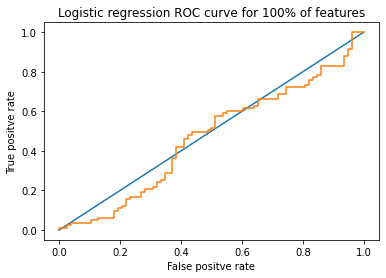

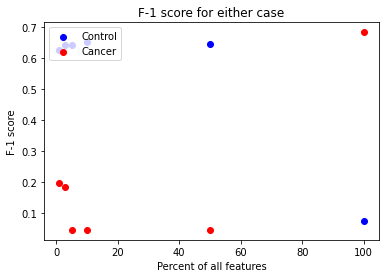

In [69]:
tmp_file_name = os.path.join(results_path, 'CancerStatus_LogReg_RankedFeats.pickle')
if not os.path.exists(tmp_file_name):
    # Define hyperparameter grid.
    c_space = np.logspace(-5, 8, 15)
    param_grid = {'model__C': c_space, 'model__penalty': ['l1', 'l2']}
    # Define model
    tmp_model = LogisticRegression(solver='liblinear')
    # Instance accordingly.
    logreg_instances = GeneralClassifierPipeline(tmp_model, 'Logistic regression', param_grid, defined_range=[1, 3, 5, 10, 50, 100], search_scoring='roc_auc', cv_no=5)
    # Save results
    SaveObj(logreg_instances, 'CancerStatus_LogReg_RankedFeats')
else:
    file = open(tmp_file_name, 'rb')
    logreg_instances = pickle.load(file)
    file.close()

### SVM\

Instancing models.
All models have been instanced.
Best average ROC AUC is: 0.996
Best parameters:
{'model__kernel': 'sigmoid', 'model__gamma': 'scale', 'model__C': 163789.3706954068}
This model's ROC AUC for the testing dataset is: 0.468


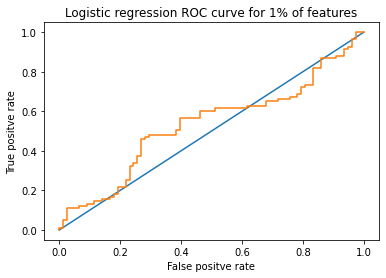

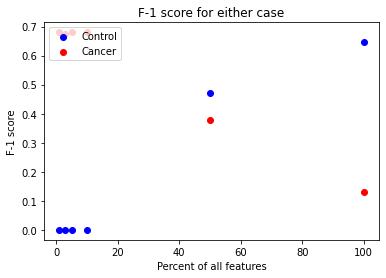

In [70]:
tmp_file_name = os.path.join(results_path, 'CancerStatus_SVM_RankedFeats.pickle')
if not os.path.exists(tmp_file_name):
    # Define hyperparameter grid.
    c_space = np.logspace(-5, 8, 15)
    kernel_space = ['linear', 'poly', 'rbf', 'sigmoid']
    gamma_space = ['scale', 'auto']
    param_grid = {'model__C': c_space, 'model__kernel': kernel_space, 'model__gamma': gamma_space}
    # Define model
    tmp_model = SVC(probability=True)
    # Instance accordingly.
    svm_instances = GeneralClassifierPipeline(tmp_model, 'SVM', param_grid, defined_range=[1, 3, 5, 10, 50, 100], search_scoring='roc_auc', cv_no=5)
    # Save results
    SaveObj(svm_instances, 'CancerStatus_SVM_RankedFeats')
else:
    file = open(tmp_file_name, 'rb')
    svm_instances = pickle.load(file)
    file.close()

### Random forests\

Instancing models.
All models have been instanced.
Best average ROC AUC is: 0.906
Best parameters:
{'model__n_estimators': 170, 'model__criterion': 'gini'}
This model's ROC AUC for the testing dataset is: 0.578


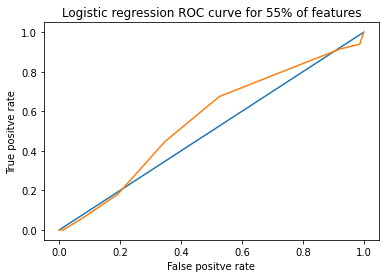

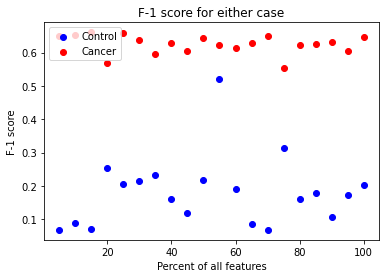

In [76]:
tmp_file_name = os.path.join(results_path, 'CancerStatus_RandomForests_RankedFeats.pickle')
if not os.path.exists(tmp_file_name):
    # Define hyperparameter grid.
    estimators_space = np.arange(10, 210, 10)
    # criterion_space = ['gini', 'entropy', 'log_loss']
    criterion_space = ['gini', 'entropy']
    param_grid = {'model__n_estimators': estimators_space, 'model__criterion': criterion_space}
    # Define model
    tmp_model = RandomForestClassifier()
    # Instance accordingly.
    rforests_instances = GeneralClassifierPipeline(tmp_model, 'Random forests', param_grid, cv_no=5)
    # Save results
    SaveObj(rforests_instances, 'CancerStatus_RandomForests_RankedFeats')
else:
    file = open(tmp_file_name, 'rb')
    rforests_instances = pickle.load(file)
    file.close()

# Cancer prediction according to features grouped based on biotype\

### Define general pipeline to train models according to ranked gene subset\

In [73]:
def ClassifierPipelinePerBiotype(clas_model, model_lab, param_grid, type_count_thold=200, search_scoring='accuracy', cv_no=5):
    # ---> Define biotypes to try.
    type_counts = gene_types['biotype'].value_counts()
    biotypes_to_try = type_counts[type_counts > type_count_thold].index.values
    # ---> Define objects to save the models and the reports on testing data.
    model_list = list()
    eval_list = list()
    scores_list = list()
    # ---> Apply pipeline to each subset.
    print('Instancing models.')
    for biotype in biotypes_to_try:
#         print('Percent of data:' + str(i))
        # Select data subsets.
        feat_subset = gene_types.loc[gene_types['biotype']==biotype, 'gene_id']
        feat_subset = feat_subset[feat_subset.isin(X_train.columns.values)].values
        X_train_subset = X_train.loc[:, feat_subset].values
        X_test_subset = X_test.loc[:, feat_subset].values
        # Set up pipeline.
        steps = [('scaler', StandardScaler()), ('model', clas_model)]
        model_pipeline = Pipeline(steps)
        # Instantiate the GridSearchCV object.
        model_cv = RandomizedSearchCV(model_pipeline, param_grid, cv_no, scoring=search_scoring)
        # Fit it to the training data
        model_cv.fit(X_train_subset, y_train.ravel())
        model_list.append(model_cv)
        # Print the optimal parameters and best score
        y_pred = model_cv.predict(X_test_subset)
        class_report = classification_report(y_test, y_pred, output_dict=True)
        eval_list.append(class_report)
        # Final score.
        scores_list.append(model_cv.score(X_test_subset, y_test))
    print('All models have been instanced.')
    # ---> Output ROC curve for best score.
    # Identify best score.
    best_score = max(scores_list)
    for i in range(0, len(scores_list)):
        if scores_list[i] == best_score:
            best_model_i = i
            break
    print('Best biotype is: ' + biotypes_to_try[best_model_i])
    print('Best average ROC AUC is: ' + str(np.round(model_cv.best_score_, 3)))
    print('Best parameters:')
    print(model_cv.best_params_)
    print('This model\'s ROC AUC for the testing dataset is: ' + str(np.round(best_score, 3)))
    # Get susbet accordingly.
    feat_subset = gene_types.loc[gene_types['biotype']==biotypes_to_try[best_model_i], 'gene_id']
    feat_subset = feat_subset[feat_subset.isin(X_train.columns.values)].values
    X_test_subset = X_test.loc[:, feat_subset].values
    # Calculate TPR and FPRs.
    y_pred_prob = model_list[best_model_i].predict_proba(X_test_subset)[:, 1]
    fpr, tpr, tholds = roc_curve(y_test, y_pred_prob)
    # Output plot.
    plt.plot([0, 1], [0, 1])
    plt.plot(fpr, tpr, label=model_lab)
    plt.xlabel('False positve rate')
    plt.ylabel('True positve rate')
    plt.title('ROC curve for biotype: ' + biotypes_to_try[best_model_i])
    plt.show()
    # ---> Output F-1 scores.
    # Get F-1 scores for each class.
    ctrl_scores = [i['0']['f1-score'] for i in eval_list]
    cancer_scores = [i['1']['f1-score'] for i in eval_list]
    # Plot.
    plt.plot()
    plt.scatter(biotypes_to_try, ctrl_scores, c='blue', label='Control')
    plt.scatter(biotypes_to_try, cancer_scores, c='red', label='Cancer')
    plt.xlabel('Percent of all features')
    plt.ylabel('F-1 score')
    plt.title('F-1 score for either case')
    plt.legend(loc="upper left")
    plt.show()
    # ---> Output calculated data.
    output = {'model_lab': model_lab, 'biotypes': biotypes_to_try, 'model_list':model_list, 'eval_list':eval_list, 'scores_list':scores_list, 'best_model_i':best_model_i}
    return output

### Logistic regression\

Instancing models.
All models have been instanced.
Best biotype is: snoRNA
Best average ROC AUC is: 0.923
Best parameters:
{'model__penalty': 'l1', 'model__C': 268.2695795279727}
This model's ROC AUC for the testing dataset is: 0.6


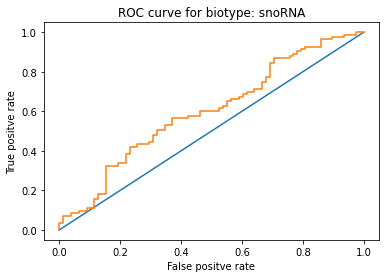

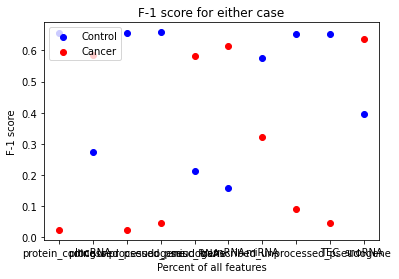

In [74]:
tmp_file_name = os.path.join(results_path, 'CancerStatus_LogReg_Biotypes.pickle')
if not os.path.exists(tmp_file_name):
    # Define hyperparameter grid.
    c_space = np.logspace(-5, 8, 15)
    param_grid = {'model__C': c_space, 'model__penalty': ['l1', 'l2']}
    # Define model
    tmp_model = LogisticRegression(solver='liblinear')
    # Instance accordingly.
    logreg_btype_instances = ClassifierPipelinePerBiotype(tmp_model, 'Logistic regression', param_grid, search_scoring='roc_auc', cv_no=5, type_count_thold=1000)
    # Save results
    SaveObj(logreg_btype_instances, 'CancerStatus_LogReg_Biotypes')
else:
    file = open(tmp_file_name, 'rb')
    logreg_btype_instances = pickle.load(file)
    file.close()

### SVM\

Instancing models.
All models have been instanced.
Best biotype is: snoRNA
Best average ROC AUC is: 0.714
Best parameters:
{'model__kernel': 'linear', 'model__gamma': 'auto', 'model__C': 1e-05}
This model's ROC AUC for the testing dataset is: 0.586


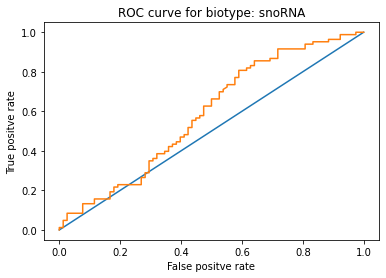

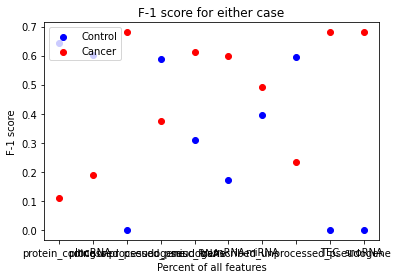

In [78]:
tmp_file_name = os.path.join(results_path, 'CancerStatus_SVM_Biotypes.pickle')
if not os.path.exists(tmp_file_name):
    # Define hyperparameter grid.
    c_space = np.logspace(-5, 8, 15)
    kernel_space = ['linear', 'poly', 'rbf', 'sigmoid']
    gamma_space = ['scale', 'auto']
    param_grid = {'model__C': c_space, 'model__kernel': kernel_space, 'model__gamma': gamma_space}
    # Define model
    tmp_model = SVC(probability=True)
    # Instance accordingly.
    svm_btype_instances = ClassifierPipelinePerBiotype(tmp_model, 'SVM', param_grid, search_scoring='roc_auc', cv_no=5, type_count_thold=1000)
    # Save results
    SaveObj(svm_btype_instances, 'CancerStatus_SVM_Biotypes')
else:
    file = open(tmp_file_name, 'rb')
    svm_btype_instances = pickle.load(file)
    file.close()

### Random forests\

Instancing models.
All models have been instanced.
Best biotype is: snoRNA
Best average ROC AUC is: 0.892
Best parameters:
{'model__n_estimators': 70, 'model__criterion': 'entropy'}
This model's ROC AUC for the testing dataset is: 0.628


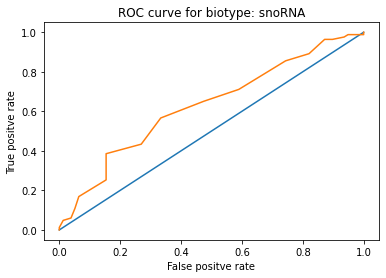

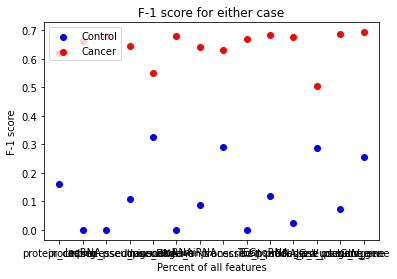

In [80]:
tmp_file_name = os.path.join(results_path, 'CancerStatus_RandomForests_Biotypes.pickle')
if not os.path.exists(tmp_file_name):
    # Define hyperparameter grid.
    estimators_space = np.arange(10, 210, 10)
    # criterion_space = ['gini', 'entropy', 'log_loss']
    criterion_space = ['gini', 'entropy']
    param_grid = {'model__n_estimators': estimators_space, 'model__criterion': criterion_space}
    # Define model
    tmp_model = RandomForestClassifier()
    # Instance accordingly.
    rforests_btype_instances = ClassifierPipelinePerBiotype(tmp_model, 'Random forests', param_grid, search_scoring='roc_auc', cv_no=100)
    # Save results
    SaveObj(rforests_btype_instances, 'CancerStatus_RandomForests_Biotypes')
else:
    file = open(tmp_file_name, 'rb')
    rforests_btype_instances = pickle.load(file)
    file.close()

### Random forests 2\

Instancing models.
All models have been instanced.
Best biotype is: snoRNA
Best average ROC AUC is: 0.883
Best parameters:
{'model__n_estimators': 170, 'model__criterion': 'entropy'}
This model's ROC AUC for the testing dataset is: 0.596


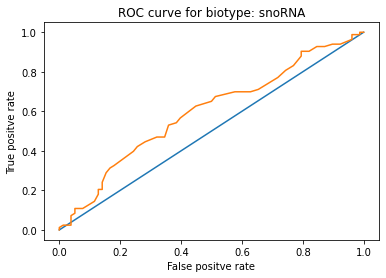

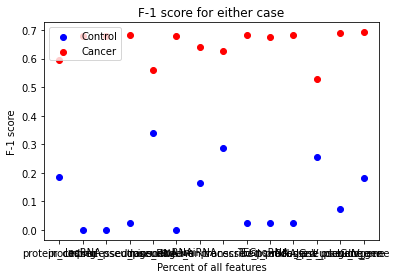

In [82]:
tmp_file_name = os.path.join(results_path, 'CancerStatus_RandomForests_Biotypes-2.pickle')
if not os.path.exists(tmp_file_name):
    # Define hyperparameter grid.
    estimators_space = np.arange(10, 210, 10)
    # criterion_space = ['gini', 'entropy', 'log_loss']
    criterion_space = ['gini', 'entropy']
    param_grid = {'model__n_estimators': estimators_space, 'model__criterion': criterion_space}
    # Define model
    tmp_model = RandomForestClassifier()
    # Instance accordingly.
    rforests_btype_instances_2 = ClassifierPipelinePerBiotype(tmp_model, 'Random forests', param_grid, search_scoring='roc_auc', cv_no=250)
    # Save results
    SaveObj(rforests_btype_instances_2, 'CancerStatus_RandomForests_Biotypes-2')
else:
    file = open(tmp_file_name, 'rb')
    rforests_btype_instances_2 = pickle.load(file)
    file.close()

# Cancer prediction according to features grouped based on biotype, log-transformed data\

In [47]:
def ClassifierPipelinePerBiotypeLog(clas_model, model_lab, param_grid, type_count_thold=200, search_scoring='accuracy', cv_no=5):
    # ---> Define biotypes to try.
    type_counts = gene_types['biotype'].value_counts()
    biotypes_to_try = type_counts[type_counts > type_count_thold].index.values
    # ---> Define objects to save the models and the reports on testing data.
    model_list = list()
    eval_list = list()
    scores_list = list()
    # ---> Apply pipeline to each subset.
    print('Instancing models.')
    for biotype in biotypes_to_try:
#         print('Percent of data:' + str(i))
        # Select data subsets.
        feat_subset = gene_types.loc[gene_types['biotype']==biotype, 'gene_id']
        feat_subset = feat_subset[feat_subset.isin(X_train.columns.values)].values
        X_train_subset = X_train.loc[:, feat_subset].values
        X_test_subset = X_test.loc[:, feat_subset].values
        # Set up pipeline.
        steps = [('model', clas_model)]
        model_pipeline = Pipeline(steps)
        # Instantiate the GridSearchCV object.
        model_cv = RandomizedSearchCV(model_pipeline, param_grid, cv_no, scoring=search_scoring)
        # Fit it to the training data
        model_cv.fit(np.log2(X_train_subset+1), y_train.ravel())
        model_list.append(model_cv)
        # Print the optimal parameters and best score
        y_pred = model_cv.predict(np.log2(X_test_subset+1))
        class_report = classification_report(y_test, y_pred, output_dict=True)
        eval_list.append(class_report)
        # Final score.
        scores_list.append(model_cv.score(np.log2(X_test_subset+1), y_test))
    print('All models have been instanced.')
    # ---> Output ROC curve for best score.
    # Identify best score.
    best_score = max(scores_list)
    for i in range(0, len(scores_list)):
        if scores_list[i] == best_score:
            best_model_i = i
            break
    print('Best biotype is: ' + biotypes_to_try[best_model_i])
    print('Best average ROC AUC is: ' + str(np.round(model_cv.best_score_, 3)))
    print('This model\'s ROC AUC for the testing dataset is: ' + str(np.round(best_score, 3)))
    # Get susbet accordingly.
    feat_subset = gene_types.loc[gene_types['biotype']==biotypes_to_try[best_model_i], 'gene_id']
    feat_subset = feat_subset[feat_subset.isin(X_train.columns.values)].values
    X_test_subset = X_test.loc[:, feat_subset].values
    # Calculate TPR and FPRs.
    y_pred_prob = model_list[best_model_i].predict_proba(np.log2(X_test_subset+1))[:, 1]
    fpr, tpr, tholds = roc_curve(y_test, y_pred_prob)
    # Output plot.
    plt.plot([0, 1], [0, 1])
    plt.plot(fpr, tpr, label=model_lab)
    plt.xlabel('False positve rate')
    plt.ylabel('True positve rate')
    plt.title('Logistic regression ROC curve for biotype: ' + biotypes_to_try[best_model_i])
    plt.show()
    # ---> Output F-1 scores.
    # Get F-1 scores for each class.
    ctrl_scores = [i['0']['f1-score'] for i in eval_list]
    cancer_scores = [i['1']['f1-score'] for i in eval_list]
    # Plot.
    plt.plot()
    plt.scatter(biotypes_to_try, ctrl_scores, c='blue', label='Control')
    plt.scatter(biotypes_to_try, cancer_scores, c='red', label='Cancer')
    plt.xlabel('Percent of all features')
    plt.ylabel('F-1 score')
    plt.title('F-1 score for either case')
    plt.legend(loc="upper left")
    plt.show()
    # ---> Output calculated data.
    model_list = list()
    eval_list = list()
    scores_list = list()
    output = {'model_lab': model_lab, 'biotypes': biotypes_to_try, 'model_list':model_list, 'eval_list':eval_list, 'scores_list':scores_list, 'best_model_i':best_model_i}
    return output

### SVM\

Instancing models.
All models have been instanced.
Best biotype is: transcribed_unprocessed_pseudogene
Best average ROC AUC is: 0.998
This model's ROC AUC for the testing dataset is: 0.496


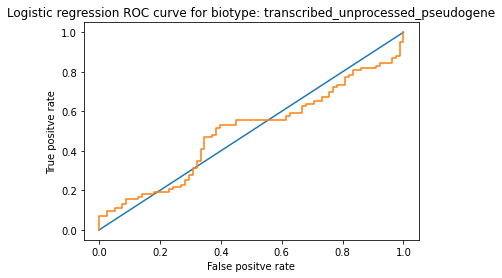

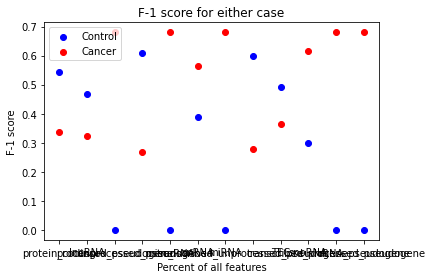

In [52]:
tmp_file_name = os.path.join(results_path, 'CancerStatus_SVM_Biotypes-Log2-2.pickle')
if not os.path.exists(tmp_file_name):
    # Define hyperparameter grid.
    c_space = np.logspace(-5, 8, 15)
    kernel_space = ['linear', 'poly', 'rbf', 'sigmoid']
    gamma_space = ['scale', 'auto']
    param_grid = {'model__C': c_space, 'model__kernel': kernel_space, 'model__gamma': gamma_space}
    # Define model
    tmp_model = SVC(probability=True)
    # Instance accordingly.
    svm_btype_log_instances = ClassifierPipelinePerBiotypeLog(tmp_model, 'SVM', param_grid, search_scoring='roc_auc', cv_no=100, type_count_thold=500)
    # Save results
    SaveObj(svm_btype_log_instances, 'CancerStatus_SVM_Biotypes-Log2')
else:
    file = open(tmp_file_name, 'rb')
    svm_btype_log_instances = pickle.load(file)
    file.close()